In [1]:
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import time
from datetime import timedelta

# Load pickled data
import pickle
import os
from sklearn.utils import shuffle
# TODO: fill this in based on where you saved the training and testing data
%matplotlib inline

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train_yuv, y_train = train['features'], train['labels']
X_test_yuv, y_test = test['features'], test['labels']
print('Data and modules loaded.')
del train, test

Data and modules loaded.


In [2]:
# Pre-processing
X_train_yuv = tf.Variable(X_train_yuv)
X_test_yuv = tf.Variable(X_test_yuv)

session = tf.Session()
session.run(tf.initialize_all_variables())

X_train_yuv = tf.image.rgb_to_grayscale(X_train_yuv)
X_test_yuv = tf.image.rgb_to_grayscale(X_test_yuv)

X_train_yuv = session.run(X_train_yuv)
X_test_yuv = session.run(X_test_yuv)

# shuffle them 5 times
for i in range(5):
    X_train_yuv, y_train = shuffle(X_train_yuv, y_train, random_state=i)
    X_test_yuv, y_test = shuffle(X_test_yuv, y_test, random_state=i)

print('X_train type ', type(X_train_yuv))
print('X_test type: ', type(X_test_yuv))
print(X_train_yuv.shape)
print(X_test_yuv.shape)
print(y_train.shape)
print(y_test.shape)


X_train type  <class 'numpy.ndarray'>
X_test type:  <class 'numpy.ndarray'>
(39209, 32, 32, 1)
(12630, 32, 32, 1)
(39209,)
(12630,)


In [3]:
print()

In [4]:
img_num = X_train_yuv.shape[0]
img_height = X_train_yuv.shape[1]
img_width = X_train_yuv.shape[2]
num_channel = X_train_yuv.shape[3]
n_classes = len(set(y_train))

In [5]:
x = tf.placeholder(tf.float32, shape=[None, img_height, img_width, 1], name='x')

# Todo may need to be changed
y_true = tf.placeholder(tf.int64, shape=[None], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.
fc_size = 128             # Number of neurons in fully-connected layer.


In [6]:
from model_arch import *
layer_conv1, weights_conv1 = new_conv_layer(input=x, num_input_channels=num_channel, filter_size=filter_size1,
                                            num_filters=num_filters1, use_pooling=True)
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1,
                                            filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=n_classes, use_relu=False)

y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

# y_true is in 1-d shape, sparse_softmax_cross_entroy_with_logits can do auto one-hot encoding.
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

# Performance measure
correct_prediction = tf.equal(y_pred_cls, y_true) # if it is processed inside the session
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

session.run(tf.initialize_all_variables())

train_batch_size = 64
total_iterations = 0

In [7]:
def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    batch_index = np.array(range(train_batch_size))

    for i in range(total_iterations, total_iterations + num_iterations):
        # x_batch, y_true_batch = data.train.next_batch(train_batch_size) # numpy array
        try:
            x_batch = X_train_yuv[batch_index]
            y_true_batch = y_train[batch_index]
            batch_index += train_batch_size
            # re-count batches from index 0
            batch_index = batch_index % img_num
        except IndexError:
            print('lance out of index: ', batch_index)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [8]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    images = X_test_yuv[incorrect]

    cls_pred = cls_pred[incorrect]

    cls_true = y_test[incorrect]
    
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [9]:
def plot_confusion_matrix(cls_pred):
    cls_true = y_test
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [10]:
test_batch_size = 256

In [11]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    num_test = len(y_test)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        images = X_test_yuv[i:j]
        labels = y_test[i:j]
        # labels should be
        feed_dict = {x: images, y_true: labels}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = y_test

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [12]:
from model_arch import *

In [13]:
def plot_images(images, cls_true, cls_pred=None):
    print('images length is: ', images.shape)
    print('cls_true length is: ', cls_true.shape)
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        print('i: ', i)
        print('ax: ', ax)
        # ax.imshow(images[i], cmap='binary')
        ax.imshow(np.squeeze(images[i], axis=(2, )))
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


Accuracy on Test-Set: 1.4% (181 / 12630)
Optimization Iteration:      1, Training Accuracy:  12.5%
Time usage: 0:00:00
Accuracy on Test-Set: 4.5% (567 / 12630)
Time usage: 0:00:12
Accuracy on Test-Set: 15.3% (1932 / 12630)
Example errors:
images length is:  (9, 32, 32, 1)
cls_true length is:  (9,)
i:  0
ax:  Axes(0.125,0.684722;0.215278x0.215278)
i:  1
ax:  Axes(0.404861,0.684722;0.215278x0.215278)
i:  2
ax:  Axes(0.684722,0.684722;0.215278x0.215278)
i:  3
ax:  Axes(0.125,0.404861;0.215278x0.215278)
i:  4
ax:  Axes(0.404861,0.404861;0.215278x0.215278)
i:  5
ax:  Axes(0.684722,0.404861;0.215278x0.215278)
i:  6
ax:  Axes(0.125,0.125;0.215278x0.215278)
i:  7
ax:  Axes(0.404861,0.125;0.215278x0.215278)
i:  8
ax:  Axes(0.684722,0.125;0.215278x0.215278)


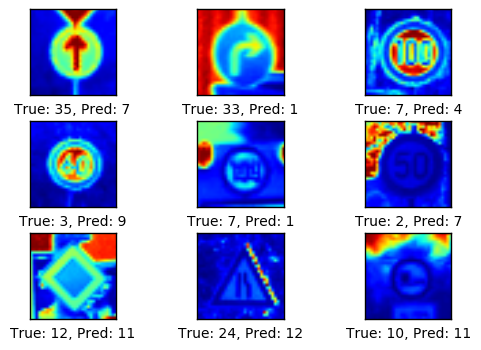

Optimization Iteration:    101, Training Accuracy:  17.2%
Optimization Iteration:    201, Training Accuracy:  28.1%
Optimization Iteration:    301, Training Accuracy:  40.6%
Optimization Iteration:    401, Training Accuracy:  67.2%
Optimization Iteration:    501, Training Accuracy:  65.6%
Optimization Iteration:    601, Training Accuracy:  73.4%
Optimization Iteration:    701, Training Accuracy:  76.6%
Optimization Iteration:    801, Training Accuracy:  75.0%
Optimization Iteration:    901, Training Accuracy:  81.2%
Optimization Iteration:   1001, Training Accuracy:  85.9%
Optimization Iteration:   1101, Training Accuracy:  82.8%
Optimization Iteration:   1201, Training Accuracy:  82.8%
Optimization Iteration:   1301, Training Accuracy:  87.5%
Optimization Iteration:   1401, Training Accuracy:  81.2%
Optimization Iteration:   1501, Training Accuracy:  85.9%
Optimization Iteration:   1601, Training Accuracy:  90.6%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization I

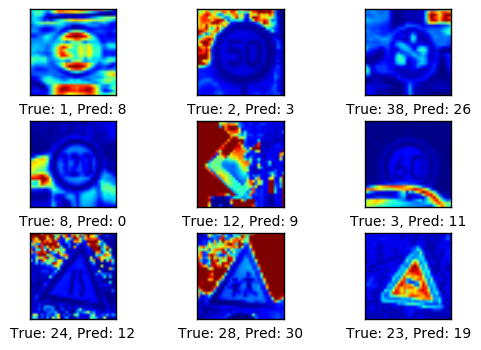

In [14]:
# print(y_test[0])

# print(y_train)

print_test_accuracy()

optimize(num_iterations=1)

print_test_accuracy()

optimize(num_iterations=99)  # We already performed 1 iteration above.

print_test_accuracy(show_example_errors=True)

optimize(num_iterations=30000)  # We performed 100 iterations above.

print_test_accuracy(show_example_errors=True)

#
# print_test_accuracy()
#
# optimize(num_iterations=99)  # We already performed 1 iteration above.
#
# print_test_accuracy(show_example_errors=True)






In [16]:
optimize(num_iterations=1)

print_test_accuracy()

Optimization Iteration:  30101, Training Accuracy: 100.0%
Time usage: 0:00:00
Accuracy on Test-Set: 92.1% (11628 / 12630)


In [17]:
import matplotlib.image as mpimg

In [18]:
image = mpimg.imread('./data/test_image/resized/1.jpg')
image.shape

(32, 32, 3)

In [20]:
gray_imread = tf.image.rgb_to_grayscale(image)
gray_imread = session.run(gray_imread)
gray_imread.shape

(32, 32, 1)

In [22]:
output_label = session.run(y_pred_cls, feed_dict={x:np.expand_dims(gray_imread, axis=0)})

In [23]:
output_label

array([2])

In [24]:
type(output_label)

numpy.ndarray

In [49]:
import os

def read_image(image_path):
    image = mpimg.imread(image_path).astype('uint8')
    return image

img_stack = np.zeros((1,32,32,1))
img_list = os.listdir('./data/image/')
image_dir = './data/image/'
for image_name in img_list:
    print(image_name)
    image_path = image_dir + image_name
    if os.path.isdir(image_path):
        continue
    image = read_image(image_path)
    gray_imread = tf.image.rgb_to_grayscale(image)
    gray_imread = session.run(gray_imread)
    gray_imread = np.expand_dims(gray_imread, axis=0)
    print('gray_imread shape: ', gray_imread.shape)
    img_stack = np.concatenate((img_stack, gray_imread))
img_stack = img_stack[1:]

4.jpg
gray_imread shape:  (1, 32, 32, 1)
5.jpg
gray_imread shape:  (1, 32, 32, 1)
6.jpg
gray_imread shape:  (1, 32, 32, 1)
2.jpg
gray_imread shape:  (1, 32, 32, 1)
1.jpg
gray_imread shape:  (1, 32, 32, 1)
3.jpg
gray_imread shape:  (1, 32, 32, 1)


In [50]:
output_label = session.run(y_pred_cls, feed_dict={x:img_stack})
print(output_label)

[ 0 11  6 32  2 14]
